<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB1] - Sentiment analysis with text embedding
<!-- DESC --> A very classical example of word embedding with a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB1')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.12
Notebook id          : IMDB1
Run time             : Tuesday 09 February 2021, 19:44:34
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.4.0/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

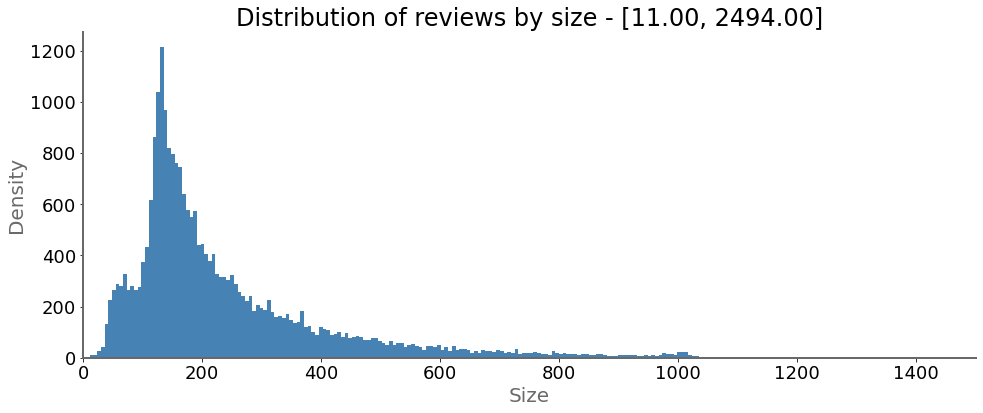

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=32):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it

In [12]:
%%time

n_epochs   = 30
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/30


 1/49 [..............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5176

 6/49 [==>...........................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5108  

12/49 [======>.......................] - ETA: 0s - loss: 0.6929 - accuracy: 0.5087

18/49 [==========>...................] - ETA: 0s - loss: 0.6928 - accuracy: 0.5070

24/49 [=============>................] - ETA: 0s - loss: 0.6927 - accuracy: 0.5097

30/49 [=================>............] - ETA: 0s - loss: 0.6925 - accuracy: 0.5182

36/49 [=====================>........] - ETA: 0s - loss: 0.6923 - accuracy: 0.5288

42/49 [========================>.....] - ETA: 0s - loss: 0.6920 - accuracy: 0.5377

48/49 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.5452

49/49 [==============================] - 3s 31ms/step - loss: 0.6916 - accuracy: 0.5475 - val_loss: 0.6803 - val_accuracy: 0.7438


Epoch 2/30
 1/49 [..............................] - ETA: 0s - loss: 0.6777 - accuracy: 0.7793

 7/49 [===>..........................] - ETA: 0s - loss: 0.6783 - accuracy: 0.7607

13/49 [======>.......................] - ETA: 0s - loss: 0.6773 - accuracy: 0.7592

19/49 [==========>...................] - ETA: 0s - loss: 0.6761 - accuracy: 0.7578

25/49 [==============>...............] - ETA: 0s - loss: 0.6748 - accuracy: 0.7562

31/49 [=================>............] - ETA: 0s - loss: 0.6734 - accuracy: 0.7554

37/49 [=====================>........] - ETA: 0s - loss: 0.6719 - accuracy: 0.7551

43/49 [=========================>....] - ETA: 0s - loss: 0.6703 - accuracy: 0.7556

49/49 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.7563

49/49 [==============================] - 1s 14ms/step - loss: 0.6684 - accuracy: 0.7564 - val_loss: 0.6226 - val_accuracy: 0.7501


Epoch 3/30
 1/49 [..............................] - ETA: 0s - loss: 0.6164 - accuracy: 0.7520

 7/49 [===>..........................] - ETA: 0s - loss: 0.6126 - accuracy: 0.7603

13/49 [======>.......................] - ETA: 0s - loss: 0.6110 - accuracy: 0.7646

19/49 [==========>...................] - ETA: 0s - loss: 0.6084 - accuracy: 0.7697

25/49 [==============>...............] - ETA: 0s - loss: 0.6053 - accuracy: 0.7746

31/49 [=================>............] - ETA: 0s - loss: 0.6020 - accuracy: 0.7784

37/49 [=====================>........] - ETA: 0s - loss: 0.5987 - accuracy: 0.7813

43/49 [=========================>....] - ETA: 0s - loss: 0.5953 - accuracy: 0.7837

49/49 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7860

49/49 [==============================] - 1s 14ms/step - loss: 0.5914 - accuracy: 0.7863 - val_loss: 0.5192 - val_accuracy: 0.8208


Epoch 4/30
 1/49 [..............................] - ETA: 0s - loss: 0.5137 - accuracy: 0.8105

 7/49 [===>..........................] - ETA: 0s - loss: 0.5057 - accuracy: 0.8194

13/49 [======>.......................] - ETA: 0s - loss: 0.5015 - accuracy: 0.8236

19/49 [==========>...................] - ETA: 0s - loss: 0.4969 - accuracy: 0.8277

25/49 [==============>...............] - ETA: 0s - loss: 0.4928 - accuracy: 0.8306

31/49 [=================>............] - ETA: 0s - loss: 0.4889 - accuracy: 0.8330

37/49 [=====================>........] - ETA: 0s - loss: 0.4852 - accuracy: 0.8351

43/49 [=========================>....] - ETA: 0s - loss: 0.4817 - accuracy: 0.8370

49/49 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.8384

49/49 [==============================] - 1s 14ms/step - loss: 0.4779 - accuracy: 0.8387 - val_loss: 0.4256 - val_accuracy: 0.8464


Epoch 5/30
 1/49 [..............................] - ETA: 0s - loss: 0.3711 - accuracy: 0.8887

 7/49 [===>..........................] - ETA: 0s - loss: 0.3864 - accuracy: 0.8783

13/49 [======>.......................] - ETA: 0s - loss: 0.3894 - accuracy: 0.8729

19/49 [==========>...................] - ETA: 0s - loss: 0.3884 - accuracy: 0.8714

25/49 [==============>...............] - ETA: 0s - loss: 0.3868 - accuracy: 0.8710

31/49 [=================>............] - ETA: 0s - loss: 0.3852 - accuracy: 0.8708

37/49 [=====================>........] - ETA: 0s - loss: 0.3833 - accuracy: 0.8709

43/49 [=========================>....] - ETA: 0s - loss: 0.3815 - accuracy: 0.8712

49/49 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8714

49/49 [==============================] - 1s 14ms/step - loss: 0.3795 - accuracy: 0.8715 - val_loss: 0.3677 - val_accuracy: 0.8602


Epoch 6/30
 1/49 [..............................] - ETA: 0s - loss: 0.3243 - accuracy: 0.9023

 7/49 [===>..........................] - ETA: 0s - loss: 0.3266 - accuracy: 0.8906

13/49 [======>.......................] - ETA: 0s - loss: 0.3252 - accuracy: 0.8899

19/49 [==========>...................] - ETA: 0s - loss: 0.3241 - accuracy: 0.8894

25/49 [==============>...............] - ETA: 0s - loss: 0.3236 - accuracy: 0.8888

31/49 [=================>............] - ETA: 0s - loss: 0.3228 - accuracy: 0.8884

37/49 [=====================>........] - ETA: 0s - loss: 0.3216 - accuracy: 0.8885

43/49 [=========================>....] - ETA: 0s - loss: 0.3206 - accuracy: 0.8885

49/49 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8885

49/49 [==============================] - 1s 14ms/step - loss: 0.3194 - accuracy: 0.8886 - val_loss: 0.3350 - val_accuracy: 0.8674


Epoch 7/30
 1/49 [..............................] - ETA: 0s - loss: 0.3095 - accuracy: 0.8926

 7/49 [===>..........................] - ETA: 0s - loss: 0.2932 - accuracy: 0.8950

13/49 [======>.......................] - ETA: 0s - loss: 0.2904 - accuracy: 0.8966

19/49 [==========>...................] - ETA: 0s - loss: 0.2883 - accuracy: 0.8975

25/49 [==============>...............] - ETA: 0s - loss: 0.2866 - accuracy: 0.8981

31/49 [=================>............] - ETA: 0s - loss: 0.2849 - accuracy: 0.8990

37/49 [=====================>........] - ETA: 0s - loss: 0.2835 - accuracy: 0.8994

43/49 [=========================>....] - ETA: 0s - loss: 0.2825 - accuracy: 0.8995

49/49 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.8995

49/49 [==============================] - 1s 14ms/step - loss: 0.2816 - accuracy: 0.8995 - val_loss: 0.3149 - val_accuracy: 0.8726


Epoch 8/30
 1/49 [..............................] - ETA: 0s - loss: 0.2446 - accuracy: 0.9121

 7/49 [===>..........................] - ETA: 0s - loss: 0.2510 - accuracy: 0.9085

13/49 [======>.......................] - ETA: 0s - loss: 0.2517 - accuracy: 0.9075

19/49 [==========>...................] - ETA: 0s - loss: 0.2511 - accuracy: 0.9077

25/49 [==============>...............] - ETA: 0s - loss: 0.2503 - accuracy: 0.9081

31/49 [=================>............] - ETA: 0s - loss: 0.2500 - accuracy: 0.9082

37/49 [=====================>........] - ETA: 0s - loss: 0.2499 - accuracy: 0.9083

43/49 [=========================>....] - ETA: 0s - loss: 0.2499 - accuracy: 0.9083

49/49 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.9083

49/49 [==============================] - 1s 14ms/step - loss: 0.2498 - accuracy: 0.9083 - val_loss: 0.3024 - val_accuracy: 0.8770


Epoch 9/30
 1/49 [..............................] - ETA: 0s - loss: 0.2371 - accuracy: 0.9180

 7/49 [===>..........................] - ETA: 0s - loss: 0.2362 - accuracy: 0.9169

13/49 [======>.......................] - ETA: 0s - loss: 0.2355 - accuracy: 0.9160

19/49 [==========>...................] - ETA: 0s - loss: 0.2338 - accuracy: 0.9164

25/49 [==============>...............] - ETA: 0s - loss: 0.2331 - accuracy: 0.9166

31/49 [=================>............] - ETA: 0s - loss: 0.2327 - accuracy: 0.9167

37/49 [=====================>........] - ETA: 0s - loss: 0.2323 - accuracy: 0.9168

43/49 [=========================>....] - ETA: 0s - loss: 0.2320 - accuracy: 0.9169

49/49 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9170

49/49 [==============================] - 1s 14ms/step - loss: 0.2314 - accuracy: 0.9171 - val_loss: 0.2942 - val_accuracy: 0.8792


Epoch 10/30
 1/49 [..............................] - ETA: 0s - loss: 0.2030 - accuracy: 0.9277

 7/49 [===>..........................] - ETA: 0s - loss: 0.2058 - accuracy: 0.9289

13/49 [======>.......................] - ETA: 0s - loss: 0.2066 - accuracy: 0.9290

19/49 [==========>...................] - ETA: 0s - loss: 0.2078 - accuracy: 0.9281

25/49 [==============>...............] - ETA: 0s - loss: 0.2083 - accuracy: 0.9276

31/49 [=================>............] - ETA: 0s - loss: 0.2083 - accuracy: 0.9275

37/49 [=====================>........] - ETA: 0s - loss: 0.2083 - accuracy: 0.9274

43/49 [=========================>....] - ETA: 0s - loss: 0.2083 - accuracy: 0.9272

49/49 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9269

49/49 [==============================] - 1s 14ms/step - loss: 0.2085 - accuracy: 0.9269 - val_loss: 0.2894 - val_accuracy: 0.8818


Epoch 11/30
 1/49 [..............................] - ETA: 0s - loss: 0.1866 - accuracy: 0.9355

 7/49 [===>..........................] - ETA: 0s - loss: 0.1952 - accuracy: 0.9300

13/49 [======>.......................] - ETA: 0s - loss: 0.1961 - accuracy: 0.9298

19/49 [==========>...................] - ETA: 0s - loss: 0.1957 - accuracy: 0.9296

25/49 [==============>...............] - ETA: 0s - loss: 0.1957 - accuracy: 0.9297

31/49 [=================>............] - ETA: 0s - loss: 0.1960 - accuracy: 0.9296

37/49 [=====================>........] - ETA: 0s - loss: 0.1961 - accuracy: 0.9296

43/49 [=========================>....] - ETA: 0s - loss: 0.1961 - accuracy: 0.9297

49/49 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9297

49/49 [==============================] - 1s 14ms/step - loss: 0.1961 - accuracy: 0.9297 - val_loss: 0.2872 - val_accuracy: 0.8824


Epoch 12/30
 1/49 [..............................] - ETA: 0s - loss: 0.2102 - accuracy: 0.9199

 7/49 [===>..........................] - ETA: 0s - loss: 0.1925 - accuracy: 0.9287

13/49 [======>.......................] - ETA: 0s - loss: 0.1893 - accuracy: 0.9307

19/49 [==========>...................] - ETA: 0s - loss: 0.1885 - accuracy: 0.9314

25/49 [==============>...............] - ETA: 0s - loss: 0.1875 - accuracy: 0.9323

31/49 [=================>............] - ETA: 0s - loss: 0.1868 - accuracy: 0.9328

37/49 [=====================>........] - ETA: 0s - loss: 0.1862 - accuracy: 0.9332

43/49 [=========================>....] - ETA: 0s - loss: 0.1856 - accuracy: 0.9335

49/49 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9337

49/49 [==============================] - 1s 14ms/step - loss: 0.1852 - accuracy: 0.9338 - val_loss: 0.2869 - val_accuracy: 0.8827


Epoch 13/30
 1/49 [..............................] - ETA: 0s - loss: 0.1780 - accuracy: 0.9375

 7/49 [===>..........................] - ETA: 0s - loss: 0.1714 - accuracy: 0.9394

13/49 [======>.......................] - ETA: 0s - loss: 0.1729 - accuracy: 0.9380

19/49 [==========>...................] - ETA: 0s - loss: 0.1732 - accuracy: 0.9378

25/49 [==============>...............] - ETA: 0s - loss: 0.1733 - accuracy: 0.9378

31/49 [=================>............] - ETA: 0s - loss: 0.1734 - accuracy: 0.9378

37/49 [=====================>........] - ETA: 0s - loss: 0.1731 - accuracy: 0.9382

43/49 [=========================>....] - ETA: 0s - loss: 0.1728 - accuracy: 0.9385

49/49 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9387

49/49 [==============================] - 1s 14ms/step - loss: 0.1728 - accuracy: 0.9387 - val_loss: 0.2883 - val_accuracy: 0.8826


Epoch 14/30
 1/49 [..............................] - ETA: 0s - loss: 0.1694 - accuracy: 0.9336

 7/49 [===>..........................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9427

13/49 [======>.......................] - ETA: 0s - loss: 0.1651 - accuracy: 0.9436

19/49 [==========>...................] - ETA: 0s - loss: 0.1645 - accuracy: 0.9440

25/49 [==============>...............] - ETA: 0s - loss: 0.1642 - accuracy: 0.9442

31/49 [=================>............] - ETA: 0s - loss: 0.1639 - accuracy: 0.9443

37/49 [=====================>........] - ETA: 0s - loss: 0.1635 - accuracy: 0.9444

43/49 [=========================>....] - ETA: 0s - loss: 0.1632 - accuracy: 0.9444

49/49 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9444

49/49 [==============================] - 1s 14ms/step - loss: 0.1629 - accuracy: 0.9444 - val_loss: 0.2909 - val_accuracy: 0.8816


Epoch 15/30
 1/49 [..............................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9551

 7/49 [===>..........................] - ETA: 0s - loss: 0.1488 - accuracy: 0.9534

13/49 [======>.......................] - ETA: 0s - loss: 0.1507 - accuracy: 0.9521

19/49 [==========>...................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9517

25/49 [==============>...............] - ETA: 0s - loss: 0.1519 - accuracy: 0.9511

31/49 [=================>............] - ETA: 0s - loss: 0.1522 - accuracy: 0.9506

37/49 [=====================>........] - ETA: 0s - loss: 0.1523 - accuracy: 0.9503

43/49 [=========================>....] - ETA: 0s - loss: 0.1523 - accuracy: 0.9501

49/49 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9499

49/49 [==============================] - 1s 14ms/step - loss: 0.1523 - accuracy: 0.9499 - val_loss: 0.2944 - val_accuracy: 0.8812


Epoch 16/30
 1/49 [..............................] - ETA: 0s - loss: 0.1232 - accuracy: 0.9629

 7/49 [===>..........................] - ETA: 0s - loss: 0.1353 - accuracy: 0.9552

13/49 [======>.......................] - ETA: 0s - loss: 0.1371 - accuracy: 0.9539

19/49 [==========>...................] - ETA: 0s - loss: 0.1383 - accuracy: 0.9534

25/49 [==============>...............] - ETA: 0s - loss: 0.1394 - accuracy: 0.9531

31/49 [=================>............] - ETA: 0s - loss: 0.1403 - accuracy: 0.9528

37/49 [=====================>........] - ETA: 0s - loss: 0.1409 - accuracy: 0.9525

43/49 [=========================>....] - ETA: 0s - loss: 0.1414 - accuracy: 0.9523

49/49 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9522

49/49 [==============================] - 1s 14ms/step - loss: 0.1418 - accuracy: 0.9522 - val_loss: 0.3007 - val_accuracy: 0.8798


Epoch 17/30
 1/49 [..............................] - ETA: 0s - loss: 0.1204 - accuracy: 0.9609

 7/49 [===>..........................] - ETA: 0s - loss: 0.1339 - accuracy: 0.9538

13/49 [======>.......................] - ETA: 0s - loss: 0.1361 - accuracy: 0.9525

19/49 [==========>...................] - ETA: 0s - loss: 0.1365 - accuracy: 0.9528

25/49 [==============>...............] - ETA: 0s - loss: 0.1368 - accuracy: 0.9532

31/49 [=================>............] - ETA: 0s - loss: 0.1366 - accuracy: 0.9537

37/49 [=====================>........] - ETA: 0s - loss: 0.1367 - accuracy: 0.9540

43/49 [=========================>....] - ETA: 0s - loss: 0.1368 - accuracy: 0.9541

49/49 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9541

49/49 [==============================] - 1s 14ms/step - loss: 0.1369 - accuracy: 0.9542 - val_loss: 0.3038 - val_accuracy: 0.8802


Epoch 18/30
 1/49 [..............................] - ETA: 0s - loss: 0.1361 - accuracy: 0.9453

 7/49 [===>..........................] - ETA: 0s - loss: 0.1335 - accuracy: 0.9537

13/49 [======>.......................] - ETA: 0s - loss: 0.1303 - accuracy: 0.9563

19/49 [==========>...................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9570

25/49 [==============>...............] - ETA: 0s - loss: 0.1294 - accuracy: 0.9572

31/49 [=================>............] - ETA: 0s - loss: 0.1293 - accuracy: 0.9572

37/49 [=====================>........] - ETA: 0s - loss: 0.1295 - accuracy: 0.9572

43/49 [=========================>....] - ETA: 0s - loss: 0.1294 - accuracy: 0.9572

49/49 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9572

49/49 [==============================] - 1s 14ms/step - loss: 0.1296 - accuracy: 0.9571 - val_loss: 0.3097 - val_accuracy: 0.8793


Epoch 19/30
 1/49 [..............................] - ETA: 0s - loss: 0.1195 - accuracy: 0.9609

 7/49 [===>..........................] - ETA: 0s - loss: 0.1189 - accuracy: 0.9623

13/49 [======>.......................] - ETA: 0s - loss: 0.1214 - accuracy: 0.9615

19/49 [==========>...................] - ETA: 0s - loss: 0.1221 - accuracy: 0.9617

25/49 [==============>...............] - ETA: 0s - loss: 0.1228 - accuracy: 0.9619

31/49 [=================>............] - ETA: 0s - loss: 0.1231 - accuracy: 0.9620

37/49 [=====================>........] - ETA: 0s - loss: 0.1232 - accuracy: 0.9619

43/49 [=========================>....] - ETA: 0s - loss: 0.1233 - accuracy: 0.9618

49/49 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9618

49/49 [==============================] - 1s 14ms/step - loss: 0.1234 - accuracy: 0.9618 - val_loss: 0.3161 - val_accuracy: 0.8788


Epoch 20/30
 1/49 [..............................] - ETA: 0s - loss: 0.1026 - accuracy: 0.9668

 7/49 [===>..........................] - ETA: 0s - loss: 0.1121 - accuracy: 0.9678

13/49 [======>.......................] - ETA: 0s - loss: 0.1137 - accuracy: 0.9671

19/49 [==========>...................] - ETA: 0s - loss: 0.1142 - accuracy: 0.9668

25/49 [==============>...............] - ETA: 0s - loss: 0.1151 - accuracy: 0.9662

31/49 [=================>............] - ETA: 0s - loss: 0.1157 - accuracy: 0.9657

37/49 [=====================>........] - ETA: 0s - loss: 0.1159 - accuracy: 0.9654

43/49 [=========================>....] - ETA: 0s - loss: 0.1160 - accuracy: 0.9652

49/49 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9649

49/49 [==============================] - 1s 14ms/step - loss: 0.1162 - accuracy: 0.9649 - val_loss: 0.3229 - val_accuracy: 0.8778


Epoch 21/30
 1/49 [..............................] - ETA: 0s - loss: 0.1081 - accuracy: 0.9590

 7/49 [===>..........................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9634

13/49 [======>.......................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9642

19/49 [==========>...................] - ETA: 0s - loss: 0.1087 - accuracy: 0.9643

25/49 [==============>...............] - ETA: 0s - loss: 0.1093 - accuracy: 0.9643

31/49 [=================>............] - ETA: 0s - loss: 0.1098 - accuracy: 0.9643

37/49 [=====================>........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9642

43/49 [=========================>....] - ETA: 0s - loss: 0.1105 - accuracy: 0.9642

49/49 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9642

49/49 [==============================] - 1s 14ms/step - loss: 0.1109 - accuracy: 0.9643 - val_loss: 0.3316 - val_accuracy: 0.8753


Epoch 22/30
 1/49 [..............................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9648

 7/49 [===>..........................] - ETA: 0s - loss: 0.1054 - accuracy: 0.9664

13/49 [======>.......................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9671

19/49 [==========>...................] - ETA: 0s - loss: 0.1080 - accuracy: 0.9673

25/49 [==============>...............] - ETA: 0s - loss: 0.1082 - accuracy: 0.9673

31/49 [=================>............] - ETA: 0s - loss: 0.1084 - accuracy: 0.9673

37/49 [=====================>........] - ETA: 0s - loss: 0.1082 - accuracy: 0.9673

43/49 [=========================>....] - ETA: 0s - loss: 0.1080 - accuracy: 0.9673

49/49 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9673

49/49 [==============================] - 1s 14ms/step - loss: 0.1078 - accuracy: 0.9673 - val_loss: 0.3408 - val_accuracy: 0.8710


Epoch 23/30
 1/49 [..............................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9805

 7/49 [===>..........................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9731

13/49 [======>.......................] - ETA: 0s - loss: 0.1010 - accuracy: 0.9718

19/49 [==========>...................] - ETA: 0s - loss: 0.1021 - accuracy: 0.9714

25/49 [==============>...............] - ETA: 0s - loss: 0.1024 - accuracy: 0.9712

31/49 [=================>............] - ETA: 0s - loss: 0.1027 - accuracy: 0.9710

37/49 [=====================>........] - ETA: 0s - loss: 0.1028 - accuracy: 0.9708

43/49 [=========================>....] - ETA: 0s - loss: 0.1028 - accuracy: 0.9707

49/49 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9706

49/49 [==============================] - 1s 14ms/step - loss: 0.1027 - accuracy: 0.9706 - val_loss: 0.3464 - val_accuracy: 0.8736


Epoch 24/30
 1/49 [..............................] - ETA: 0s - loss: 0.0796 - accuracy: 0.9805

 7/49 [===>..........................] - ETA: 0s - loss: 0.0884 - accuracy: 0.9757

13/49 [======>.......................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9765

19/49 [==========>...................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9762

25/49 [==============>...............] - ETA: 0s - loss: 0.0901 - accuracy: 0.9756

31/49 [=================>............] - ETA: 0s - loss: 0.0910 - accuracy: 0.9751

37/49 [=====================>........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9748

43/49 [=========================>....] - ETA: 0s - loss: 0.0923 - accuracy: 0.9744

49/49 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9740

49/49 [==============================] - 1s 14ms/step - loss: 0.0929 - accuracy: 0.9740 - val_loss: 0.3554 - val_accuracy: 0.8713


Epoch 25/30
 1/49 [..............................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9805

 7/49 [===>..........................] - ETA: 0s - loss: 0.0822 - accuracy: 0.9805

13/49 [======>.......................] - ETA: 0s - loss: 0.0867 - accuracy: 0.9783

19/49 [==========>...................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9774

25/49 [==============>...............] - ETA: 0s - loss: 0.0886 - accuracy: 0.9769

31/49 [=================>............] - ETA: 0s - loss: 0.0889 - accuracy: 0.9766

37/49 [=====================>........] - ETA: 0s - loss: 0.0893 - accuracy: 0.9763

43/49 [=========================>....] - ETA: 0s - loss: 0.0897 - accuracy: 0.9760

49/49 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9757

49/49 [==============================] - 1s 14ms/step - loss: 0.0900 - accuracy: 0.9756 - val_loss: 0.3639 - val_accuracy: 0.8701


Epoch 26/30
 1/49 [..............................] - ETA: 0s - loss: 0.0844 - accuracy: 0.9746

 7/49 [===>..........................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9784

13/49 [======>.......................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9772

19/49 [==========>...................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9763

25/49 [==============>...............] - ETA: 0s - loss: 0.0877 - accuracy: 0.9761

31/49 [=================>............] - ETA: 0s - loss: 0.0879 - accuracy: 0.9760

37/49 [=====================>........] - ETA: 0s - loss: 0.0879 - accuracy: 0.9759

43/49 [=========================>....] - ETA: 0s - loss: 0.0880 - accuracy: 0.9759

49/49 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9758

49/49 [==============================] - 1s 14ms/step - loss: 0.0881 - accuracy: 0.9758 - val_loss: 0.3727 - val_accuracy: 0.8703


Epoch 27/30
 1/49 [..............................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9863

 7/49 [===>..........................] - ETA: 0s - loss: 0.0721 - accuracy: 0.9821

13/49 [======>.......................] - ETA: 0s - loss: 0.0756 - accuracy: 0.9804

19/49 [==========>...................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9795

25/49 [==============>...............] - ETA: 0s - loss: 0.0787 - accuracy: 0.9791

31/49 [=================>............] - ETA: 0s - loss: 0.0793 - accuracy: 0.9789

37/49 [=====================>........] - ETA: 0s - loss: 0.0798 - accuracy: 0.9787

43/49 [=========================>....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9785

49/49 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9784

49/49 [==============================] - 1s 14ms/step - loss: 0.0808 - accuracy: 0.9784 - val_loss: 0.3817 - val_accuracy: 0.8690


Epoch 28/30
 1/49 [..............................] - ETA: 0s - loss: 0.1055 - accuracy: 0.9707

 7/49 [===>..........................] - ETA: 0s - loss: 0.0875 - accuracy: 0.9751

13/49 [======>.......................] - ETA: 0s - loss: 0.0834 - accuracy: 0.9766

19/49 [==========>...................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9771

25/49 [==============>...............] - ETA: 0s - loss: 0.0815 - accuracy: 0.9776

31/49 [=================>............] - ETA: 0s - loss: 0.0813 - accuracy: 0.9779

37/49 [=====================>........] - ETA: 0s - loss: 0.0811 - accuracy: 0.9780

43/49 [=========================>....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9782

49/49 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9783

49/49 [==============================] - 1s 14ms/step - loss: 0.0808 - accuracy: 0.9783 - val_loss: 0.3923 - val_accuracy: 0.8669


Epoch 29/30
 1/49 [..............................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9805

 7/49 [===>..........................] - ETA: 0s - loss: 0.0812 - accuracy: 0.9805

13/49 [======>.......................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9804

19/49 [==========>...................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9808

25/49 [==============>...............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9810

31/49 [=================>............] - ETA: 0s - loss: 0.0783 - accuracy: 0.9809

37/49 [=====================>........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9809

43/49 [=========================>....] - ETA: 0s - loss: 0.0778 - accuracy: 0.9809

49/49 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9808

49/49 [==============================] - 1s 14ms/step - loss: 0.0776 - accuracy: 0.9808 - val_loss: 0.4016 - val_accuracy: 0.8662


Epoch 30/30
 1/49 [..............................] - ETA: 0s - loss: 0.0577 - accuracy: 0.9902

 7/49 [===>..........................] - ETA: 0s - loss: 0.0662 - accuracy: 0.9841

13/49 [======>.......................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9832

19/49 [==========>...................] - ETA: 0s - loss: 0.0688 - accuracy: 0.9829

25/49 [==============>...............] - ETA: 0s - loss: 0.0694 - accuracy: 0.9826

31/49 [=================>............] - ETA: 0s - loss: 0.0698 - accuracy: 0.9824

37/49 [=====================>........] - ETA: 0s - loss: 0.0703 - accuracy: 0.9822

43/49 [=========================>....] - ETA: 0s - loss: 0.0706 - accuracy: 0.9821

49/49 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9820

49/49 [==============================] - 1s 14ms/step - loss: 0.0710 - accuracy: 0.9820 - val_loss: 0.4113 - val_accuracy: 0.8652


CPU times: user 41 s, sys: 3.77 s, total: 44.8 s
Wall time: 23.8 s


## Step 6 - Evaluate
### 6.1 - Training history

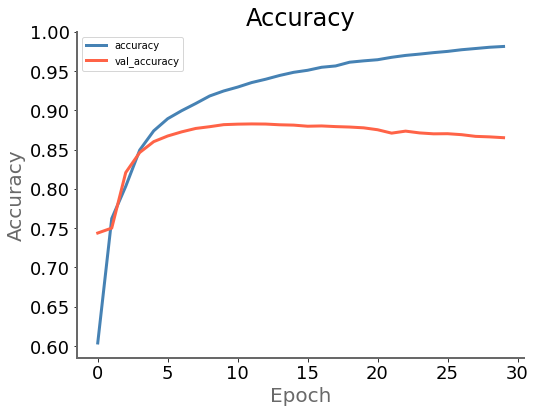

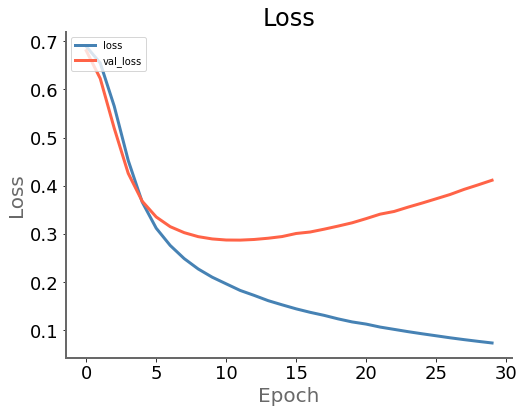

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.2869
x_test / accuracy  : 0.8827


#### Accuracy donut is :

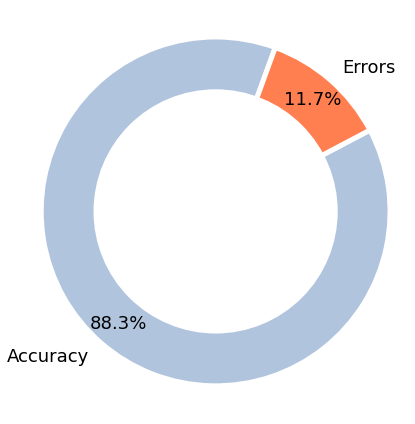

#### Confusion matrix is :

,0,1
0,0.89,0.11
1,0.12,0.88


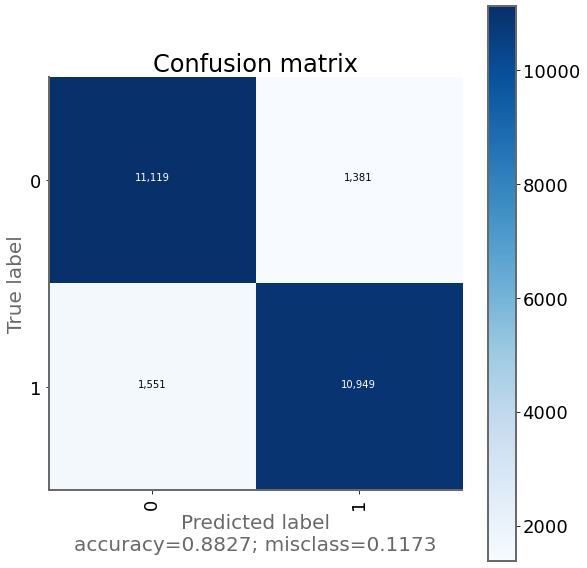

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Tuesday 09 February 2021, 19:45:19
Duration is : 00:00:45 898ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>